# Лабораторная работа №1 
## Проведение исследований с алгоритмом KNN

### 1. Выбор начальных условий

#### a. Набор данных для задачи классификации

Diabetes prediction dataset - https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

Набор данных для прогнозирования диабета представляет собой набор медицинских и демографических данных пациентов, включая информацию об их статусе диабета (положительный или отрицательный). Эти данные включают такие характеристики, как возраст, пол, индекс массы тела (ИМТ), гипертония, заболевания сердца, анамнез курения, уровень HbA1c и уровень глюкозы в крови. Этот набор данных может быть использован для построения моделей машинного обучения для прогнозирования диабета у пациентов на основе их истории болезни и демографической информации. Это может быть полезно медицинским работникам для выявления пациентов с потенциальным риском развития диабета и разработки индивидуальных планов лечения. Кроме того, этот набор данных может быть использован исследователями для изучения взаимосвязи между различными медицинскими и демографическими факторами и вероятностью развития диабета.

#### b. Набор данных для задачи регрессии

Honey purity dataset - https://www.kaggle.com/datasets/stealthtechnologies/predict-purity-and-price-of-honey

Набор данных для прогнозирования качества и цены мёда. Решение данной задачи будет полезно пчеловодам для контроля качества их продукции и обоснования ее цены.


#### c. Выбор метрик качества

##### Задача классификации:

1) $Fbeta-score$ - основная метрика. Т.к. классы несбалансированы (здоровых людей больше чем, больных диабетом), то accuracy может быть обманчивой. $Fbeta-score$ учитывает $precision$ и $recall$, что подходит для медицинской диагностики, где важно найти найти как можно больше больных (высокий $recall$), но при этом не напугать здоровых (высокий $precision$). Дает больший вес $recall$ метрике при возрастании $beta$. $beta = 1,2,3, ...$

2) $Recall$ - показывает сколько из всех рельно больных мы нашли.

3) $Precision$ - показывает сколько из всех предсказанных больных действительно больны.

4) $Accuracy$ - дополнительная метрика для общего понимания доли верных ответов.

##### Задача регрессии:

1) $MAE$ - показывает среднюю абсолютную ошибку в условных ед. Легко интерпретируется (В среднем модель ошибается на N у.е.).

2) $RMSE$ - более строгая метрика, которая сильнее штрафует за большие ошибки предсказания.

3) $R^2$ - показывает насколько модель предсказывает лучше, чем среднее значение.

### 2. Создание бейзлайна и оценка качества

#### 2.1. Обучение моделей из sklearn для решения задачи классификации и оценка качества по выбранным метрикам.

0. Подключим необходимые модули

In [43]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer

1. Загрузим датасет и посмотрим, что он из себя представляет

In [44]:
diabetes_df = pd.read_csv("datasets/diabetes_prediction_dataset.csv")

def proportional_stratified_sample(df, stratify_col, fraction=0.1, random_state=42):
    return df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(frac=fraction, random_state=random_state)
    )

diabetes_df = proportional_stratified_sample(diabetes_df, 'diabetes', fraction=0.1, random_state=42)

diabetes_df.head()

/tmp/ipykernel_3043/385779865.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(stratify_col, group_keys=False).apply(


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
21737,Female,35.0,0,0,No Info,27.32,3.5,200,0
62807,Male,66.0,0,0,No Info,27.32,4.5,145,0
38693,Male,32.0,0,0,never,32.71,6.6,90,0
72875,Male,46.0,0,0,No Info,32.78,4.0,80,0
14817,Female,22.0,0,0,never,23.51,4.5,158,0


Посмотрим информацию о датасете

In [45]:
print(diabetes_df.info())
diabetes_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 21737 to 31840
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               10000 non-null  object 
 1   age                  10000 non-null  float64
 2   hypertension         10000 non-null  int64  
 3   heart_disease        10000 non-null  int64  
 4   smoking_history      10000 non-null  object 
 5   bmi                  10000 non-null  float64
 6   HbA1c_level          10000 non-null  float64
 7   blood_glucose_level  10000 non-null  int64  
 8   diabetes             10000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 781.2+ KB
None


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,41.987140,0.072700,0.039700,27.297274,5.525780,137.635600,0.085000
std,22.475236,0.259656,0.195263,6.553449,1.069998,40.626613,0.278896
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.790000,4.800000,100.000000,0.000000
50%,42.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.000000,0.000000,29.400000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,71.550000,9.000000,300.000000,1.000000


Посмотрим сколько у нас null столбцев

In [46]:
diabetes_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Посмотрим сколько у нас повторяющихся строк

In [47]:
diabetes_df.duplicated().sum()

np.int64(52)

Посмотрим информацию о категориальных данных

In [48]:
print(diabetes_df['gender'].value_counts())
print(diabetes_df['smoking_history'].value_counts())

gender
Female    5844
Male      4154
Other        2
Name: count, dtype: int64
smoking_history
No Info        3619
never          3516
former          927
current         913
not current     645
ever            380
Name: count, dtype: int64


2. Сделаем минимально необходимую обработку и обучим модели: 

In [49]:
gender_dummies = pd.get_dummies(diabetes_df['gender'], drop_first=True)
smoking_history_dummies = pd.get_dummies(diabetes_df['smoking_history'], drop_first=True)
onehot_diabetes_df = pd.concat([diabetes_df, gender_dummies, smoking_history_dummies], axis=1)

onehot_diabetes_df.drop(['gender', 'smoking_history'], axis=1, inplace=True)

Разделим датафрейм на features и target, а также train и test

In [50]:
diabetes_X = onehot_diabetes_df.drop('diabetes', axis=1)
diabetes_y = onehot_diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

Кросс-валидация и выбор лучшей модели по fbeta-score (beta = 1,2,3)

In [51]:
from sklearn.base import clone
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()


def find_optimal_threshhold_cv(model, X, y, cv=5, f_beta=1, eps=1e-9, report=False):
    skf = StratifiedKFold(n_splits=cv)
    fold_scores = []
    models = []
    thresholds = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        fold_model = clone(model)
        fold_model.fit(X_train, y_train)
        models.append(fold_model)
        
        y_prob_val = fold_model.predict_proba(X_val)[:, 1]
        prec, rec, thresh = precision_recall_curve(y_val, y_prob_val)
        f_beta_scores = (1 + f_beta ** 2) * (prec * rec) / ((f_beta ** 2 * prec) + rec + eps)
        optimal_thresh_fold = thresh[f_beta_scores.argmax()]
        thresholds.append(optimal_thresh_fold)
        
        y_pred_val = (y_prob_val >= optimal_thresh_fold).astype(int)
        fold_scores.append({
            'classification_report': classification_report(y_val, y_pred_val),
            'f1_score': fbeta_score(y_val, y_pred_val, beta=1),
            'f2_score': fbeta_score(y_val, y_pred_val, beta=2),
            'f3_score': fbeta_score(y_val, y_pred_val, beta=3),
            'f_beta_score': fbeta_score(y_val, y_pred_val, beta=f_beta)
        })
    
    best_fold_idx = np.argmax([f['f_beta_score'] for f in fold_scores])
    best_model = models[best_fold_idx]
    best_threshold = thresholds[best_fold_idx]
    best_fold_score = fold_scores[best_fold_idx]
    
    if report:        
        print(f"\n=== Best Model f{f_beta} on validation ===")
        print(f"Best fold: {best_fold_idx + 1}")
        print(best_fold_score['classification_report'])
        print(f"Best f1-score: {best_fold_score['f1_score']:.4f}")
        print(f"Best f2-score: {best_fold_score['f2_score']:.4f}")
        print(f"Best f3-score: {best_fold_score['f3_score']:.4f}")
        print(f"Best f{f_beta}-score: {best_fold_score['f_beta_score']:.4f}")
        print(f"Best threshold: {best_threshold}")
    
    return best_model, best_threshold, best_fold_score
    

optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for f_score in [1, 2, 3]:
    optimal_models[f'f{f_score}'], optimal_thresholds[f'f{f_score}'], optimal_fold_scores[f'f{f_score}'] = find_optimal_threshhold_cv(
        model,
        diabetes_X_train,
        diabetes_y_train,
        cv=5,
        f_beta=f_score,
        report=True
    )
    


=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1464
           1       0.72      0.76      0.74       136

    accuracy                           0.95      1600
   macro avg       0.85      0.87      0.86      1600
weighted avg       0.96      0.95      0.96      1600

Best f1-score: 0.7429
Best f2-score: 0.7558
Best f3-score: 0.7602
Best f1-score: 0.7429
Best threshold: 1.0

=== Best Model f2 on validation ===
Best fold: 2
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1464
           1       0.71      0.74      0.72       136

    accuracy                           0.95      1600
   macro avg       0.84      0.86      0.85      1600
weighted avg       0.95      0.95      0.95      1600

Best f1-score: 0.7240
Best f2-score: 0.7351
Best f3-score: 0.7388
Best f2-score: 0.7351
Best threshold: 1.0

=== Best Model f3 on validati

Проведем замеры на тестовой выборке

In [52]:
for f_score in [1, 2, 3]:
    model = optimal_models[f'f{f_score}']
    threshold = optimal_thresholds[f'f{f_score}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{f_score} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{f_score}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=f_score):.4f}")    


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1830
           1       0.74      0.76      0.75       170

    accuracy                           0.96      2000
   macro avg       0.86      0.87      0.86      2000
weighted avg       0.96      0.96      0.96      2000

f1-score: 0.7478
f2-score: 0.7544
f3-score: 0.7566
f1-score: 0.7478

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1830
           1       0.76      0.74      0.75       170

    accuracy                           0.96      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.96      0.96      0.96      2000

f1-score: 0.7500
f2-score: 0.7447
f3-score: 0.7429
f2-score: 0.7447

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1830
           1       0.72      0.7

Вывод: несмотря на неплохой accuracy от 0.89 до 0.95 в зависимости от метрики, которую мы хотим оптимизировать. Видно следующее при вменяемом precision = 0.88 для определения класса "есть диабет", recall очень низкий. При стремлении увеличить recall начинает страдать precision, причем очень сильно. Это более заметно для класса "есть диабет", т.к. таких значений в разы меньше. 

### 3. Улучшение бейзлайна

#### 3.1. Задача классификации

0. Подключение модулей

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

1. Проведем более детальный анализ датасета

Вспомним, что из себя представляет датасет

In [54]:
print(f"Количество строк: {diabetes_df.shape[0]}, столбцев {diabetes_df.shape[1]}")
print(diabetes_df.info(), diabetes_df.describe())
diabetes_df.head()

Количество строк: 10000, столбцев 9
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 21737 to 31840
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               10000 non-null  object 
 1   age                  10000 non-null  float64
 2   hypertension         10000 non-null  int64  
 3   heart_disease        10000 non-null  int64  
 4   smoking_history      10000 non-null  object 
 5   bmi                  10000 non-null  float64
 6   HbA1c_level          10000 non-null  float64
 7   blood_glucose_level  10000 non-null  int64  
 8   diabetes             10000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 781.2+ KB
None                 age  hypertension  heart_disease           bmi   HbA1c_level  \
count  10000.000000  10000.000000   10000.000000  10000.000000  10000.000000   
mean      41.987140      0.072700       0.039700     27.297274      5.525780  

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
21737,Female,35.0,0,0,No Info,27.32,3.5,200,0
62807,Male,66.0,0,0,No Info,27.32,4.5,145,0
38693,Male,32.0,0,0,never,32.71,6.6,90,0
72875,Male,46.0,0,0,No Info,32.78,4.0,80,0
14817,Female,22.0,0,0,never,23.51,4.5,158,0


Посмотрим сколько значений пропущено

In [55]:
diabetes_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Какие есть уникальные категориальные значения

In [56]:
print(diabetes_df['gender'].value_counts())
print(diabetes_df['smoking_history'].value_counts())

gender
Female    5844
Male      4154
Other        2
Name: count, dtype: int64
smoking_history
No Info        3619
never          3516
former          927
current         913
not current     645
ever            380
Name: count, dtype: int64


Построим графики распределения всех людей и тех у кого диабет.

Синий - нет диабета.

Красный - есть.

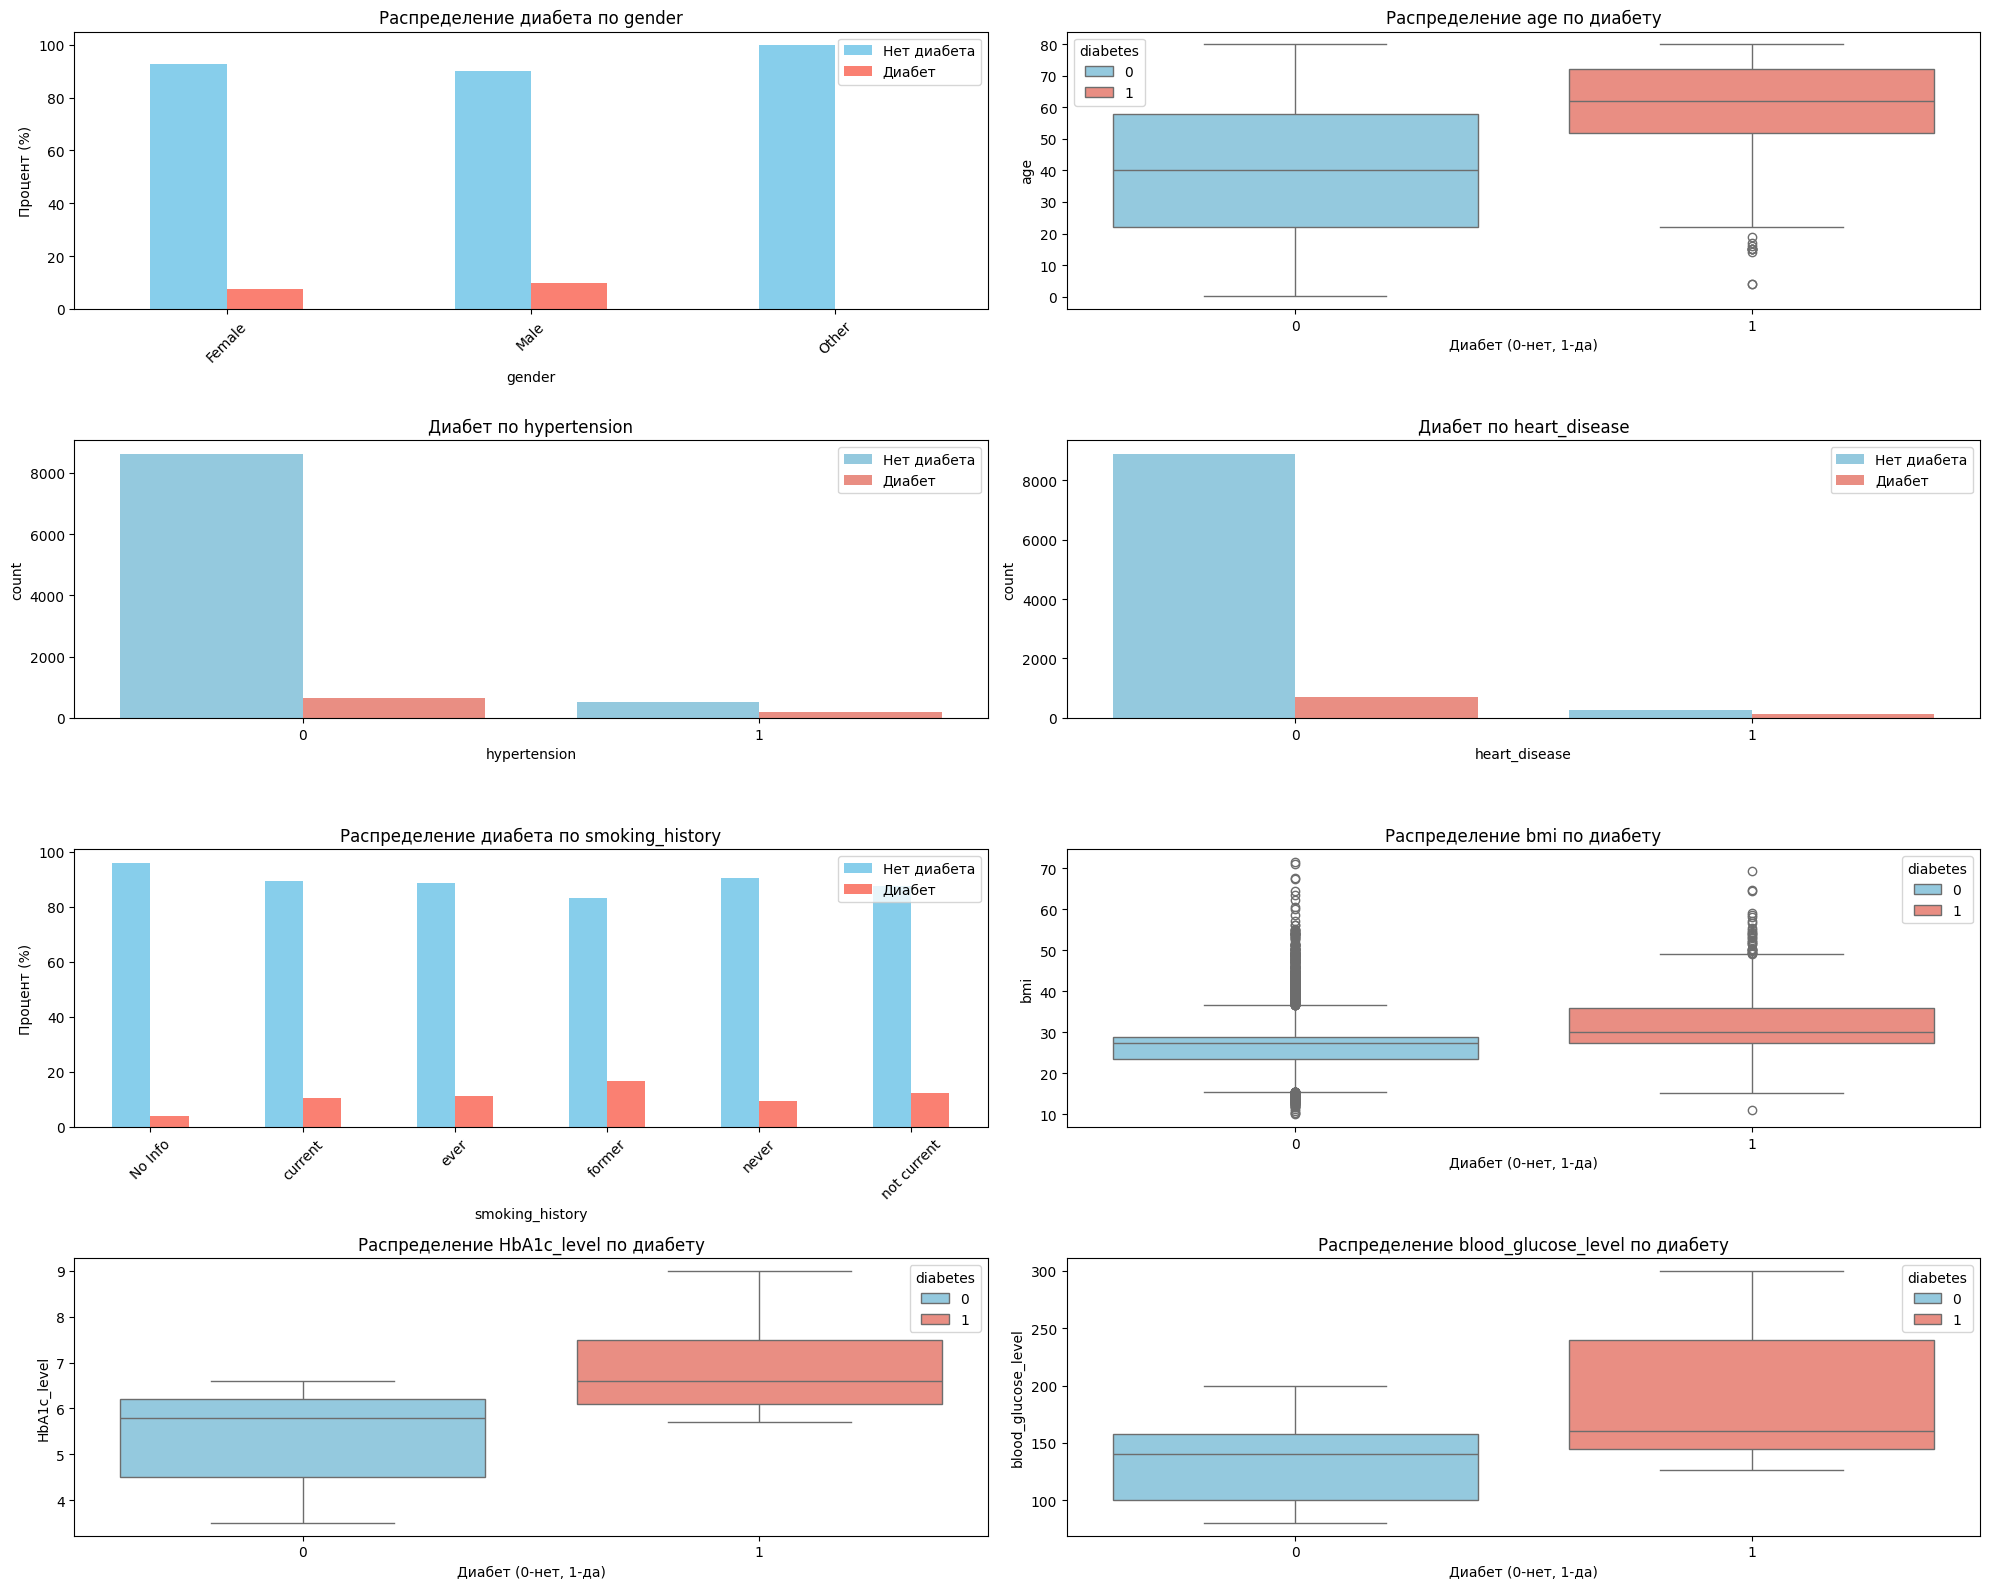

In [57]:
fig = plt.figure(figsize=(20, 16))

all_features = ['gender', 'age', 'hypertension', 'heart_disease', 
                'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']

for i, feature in enumerate(all_features, 1):
    plt.subplot(4, 2, i)
    
    if feature in ['gender', 'smoking_history']:  # Категориальные признаки
        cross_tab = pd.crosstab(diabetes_df[feature], diabetes_df['diabetes'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'salmon'])
        plt.title(f'Распределение диабета по {feature}')
        plt.ylabel('Процент (%)')
        plt.legend(['Нет диабета', 'Диабет'])
        plt.xticks(rotation=45)
        
    elif feature in ['hypertension', 'heart_disease']:  # Бинарные признаки
        sns.countplot(data=diabetes_df, x=feature, hue='diabetes', palette=['skyblue', 'salmon'])
        plt.title(f'Диабет по {feature}')
        plt.legend(['Нет диабета', 'Диабет'])
        
    else:  # Числовые признаки
        sns.boxplot(data=diabetes_df, x='diabetes', y=feature, palette=['skyblue', 'salmon'], hue='diabetes')
        plt.title(f'Распределение {feature} по диабету')
        plt.xlabel('Диабет (0-нет, 1-да)')

plt.tight_layout()
plt.show()

Из графика рапределения bmi явно видны выбросы. Их необходимо будет почистить

In [58]:
def remove_outliers_iqr_by_group(df, column, group_column):
    df_clean = df.copy()
    for group in df[group_column].unique():
        group_data = df[df[group_column] == group]
        Q1 = group_data[column].quantile(0.25)
        Q3 = group_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (df_clean[group_column] == group) & (
            (df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)
        )
        df_clean = df_clean[~outliers_mask]
    return df_clean

diabetes_clean = remove_outliers_iqr_by_group(diabetes_df, 'bmi', 'diabetes')
diabetes_clean.shape, diabetes_df.shape

((9178, 9), (10000, 9))

Посмотрим как прошли изменения

Text(0.5, 0, 'Диабет (0-нет, 1-да)')

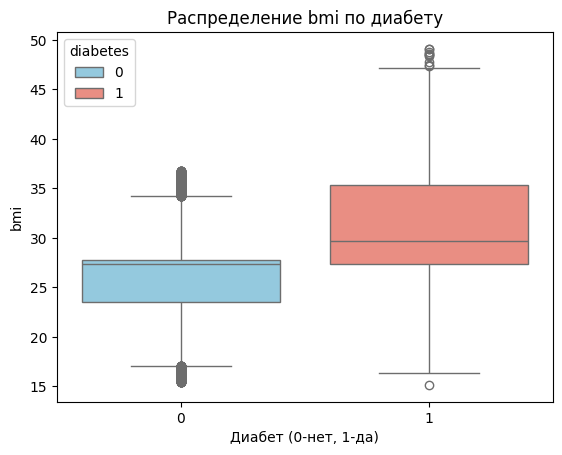

In [59]:
sns.boxplot(data=diabetes_clean, x='diabetes', y='bmi', palette=['skyblue', 'salmon'], hue='diabetes')
plt.title('Распределение bmi по диабету')
plt.xlabel('Диабет (0-нет, 1-да)')

Построим матрицу корреляции

<Figure size 1000x800 with 0 Axes>

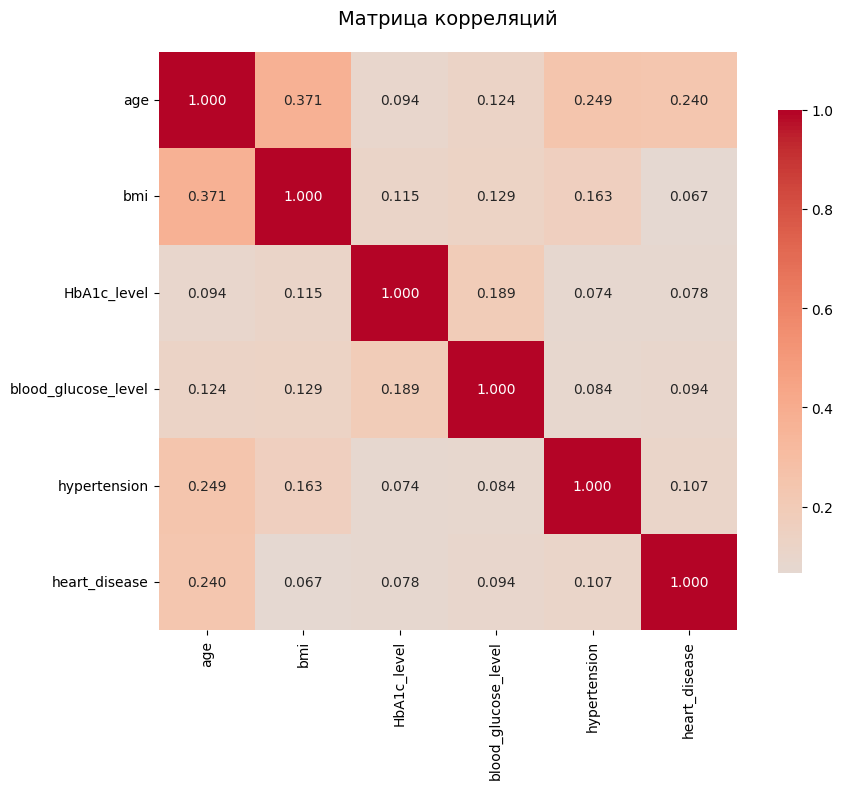

In [60]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_features = ['hypertension', 'heart_disease']

plt.figure(figsize=(10, 8))
corr_matrix = diabetes_clean[numeric_features + binary_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Построим графику зависимости между числовыми признаками

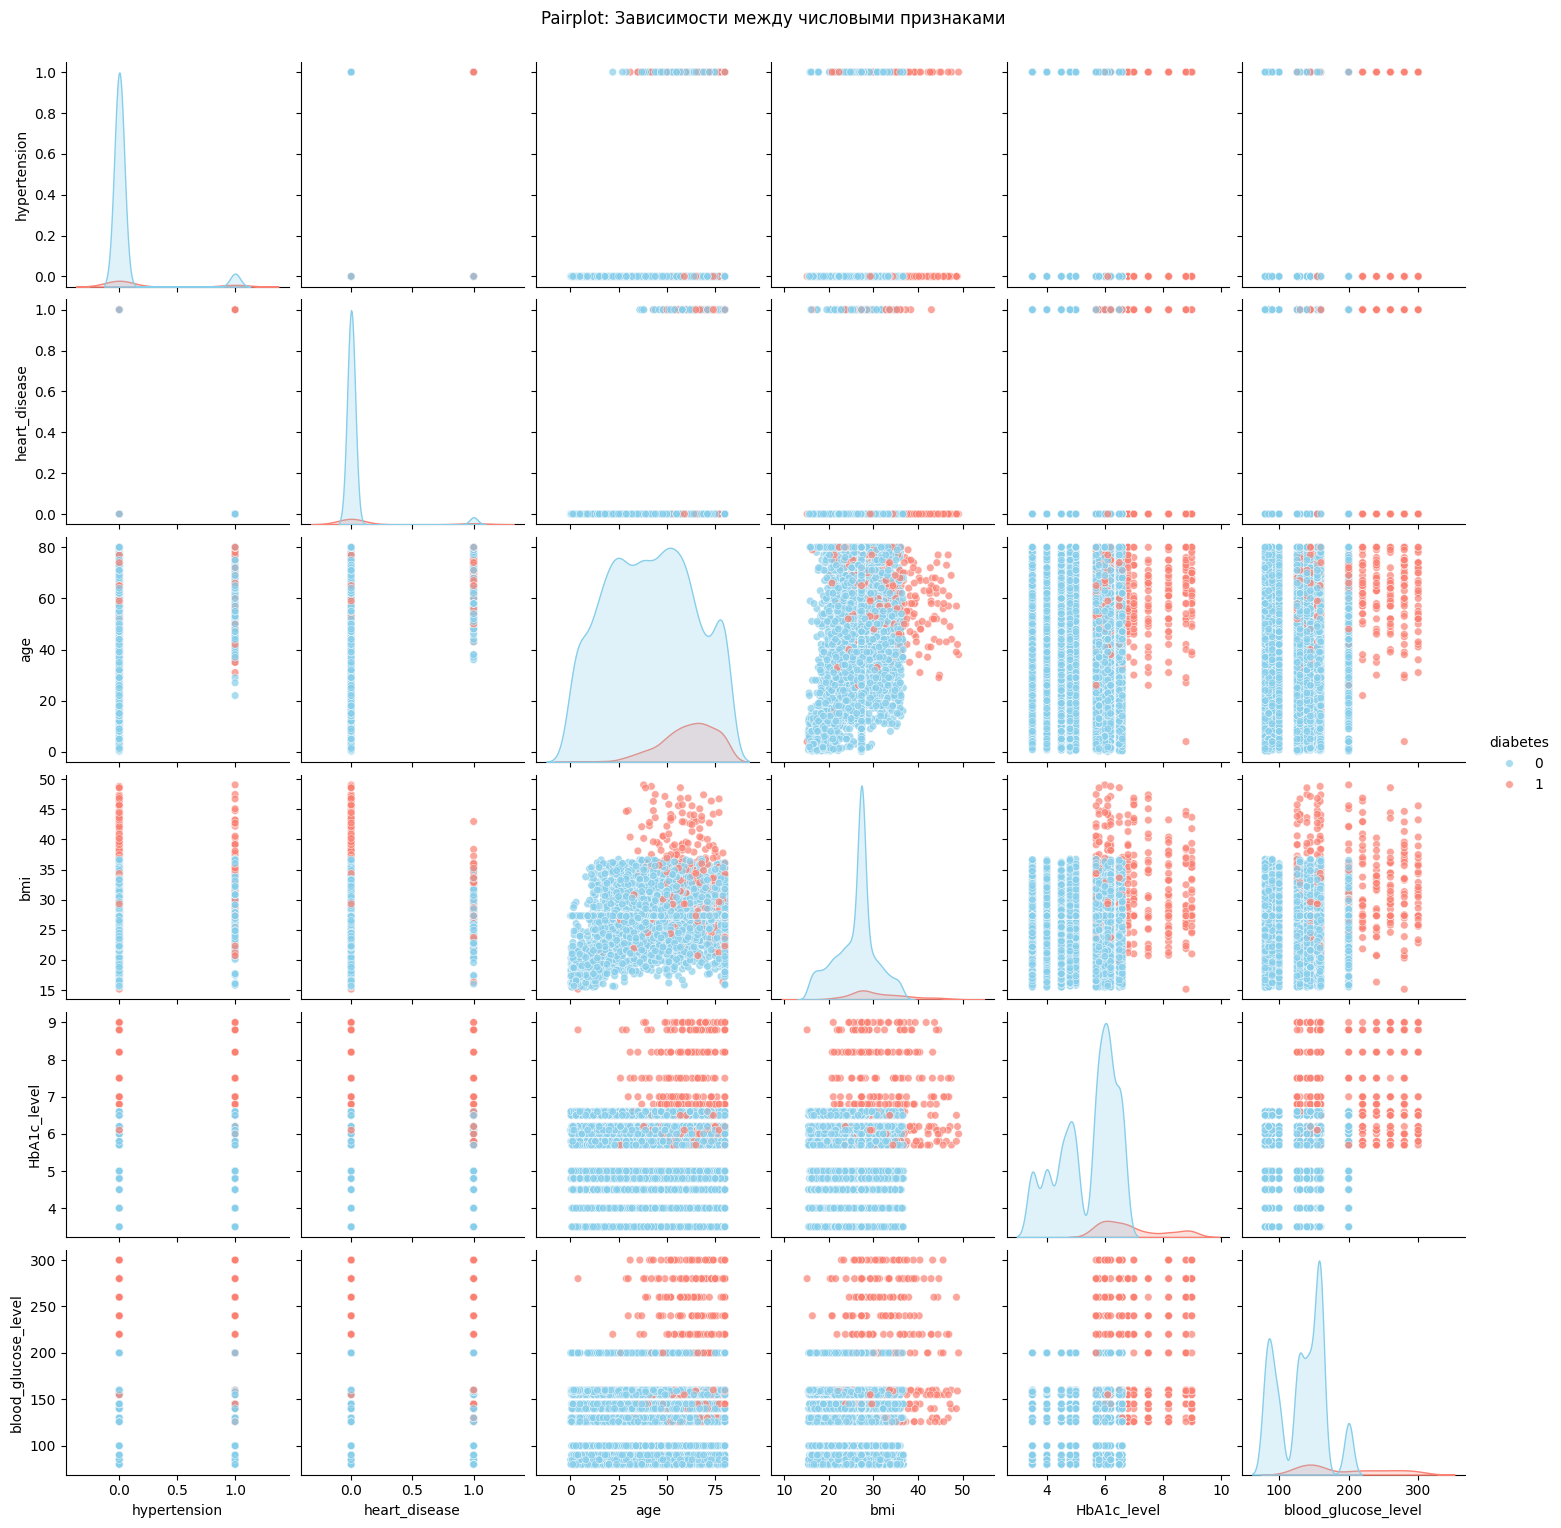

In [61]:
sns.pairplot(diabetes_clean[binary_features + numeric_features + ['diabetes']].sample(n=5000, random_state=42),
             hue='diabetes', palette=['skyblue', 'salmon'],
             diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30})
plt.suptitle('Pairplot: Зависимости между числовыми признаками', y=1.02)
plt.show()

Создадим новые фичи на основе числовых

In [62]:
def create_num_features(df):
    new_df = df.copy()
    
    new_df['log(age*bmi*HbA1c_level*blood_glucose_level+1)'] = np.log(new_df['age'] * new_df['bmi'] * new_df['HbA1c_level'] * new_df['blood_glucose_level'] + 1)

    new_df['age*bmi'] = new_df['age'] * new_df['bmi']
    new_df['HbA1c_levelxblood_glucose_level'] = new_df['HbA1c_level'] * new_df['blood_glucose_level']
    new_df['bmi*blood_glucose_level'] = new_df['bmi'] * new_df['blood_glucose_level']

    new_df['bmi*HbA1c_level*blood_glucose_level'] = new_df['bmi'] * new_df['HbA1c_level'] * new_df['blood_glucose_level']

    new_df['bmi/age'] = new_df['bmi'] / (new_df['age'] + 1e-6)
    new_df['blood_glucose_level/HbA1c_level'] = new_df['blood_glucose_level'] / (new_df['HbA1c_level'] + 1e-6)
    new_df['blood_glucose_level/age'] = new_df['blood_glucose_level'] / new_df['age']


    new_df['bmi^2'] = new_df['bmi'] ** 2
    new_df['HbA1c_level^2'] = new_df['HbA1c_level'] ** 2
    new_df['blood_glucose_level^2'] = new_df['blood_glucose_level'] ** 2

    new_df['log_blood_glucose_level+1'] = np.log(new_df['blood_glucose_level'] + 1)
    new_df['log_HbA1c_level+1'] = np.log(new_df['HbA1c_level'] + 1)
    new_df['log_bmi+1'] = np.log(new_df['bmi'] + 1)

    new_df['age_z'] = (new_df['age'] - new_df['age'].mean()) / new_df['age'].std()
    new_df['bmi_z'] = (new_df['bmi'] - new_df['bmi'].mean()) / new_df['bmi'].std()
    new_df['HbA1c_level_z'] = (new_df['HbA1c_level'] - new_df['HbA1c_level'].mean()) / new_df['HbA1c_level'].std()
    new_df['blood_glucose_level_z'] = (new_df['blood_glucose_level'] - new_df['blood_glucose_level'].mean()) / new_df['blood_glucose_level'].std()

    new_df['risk_index'] = (new_df['age_z'] + new_df['bmi_z'] + new_df['HbA1c_level_z'] + new_df['blood_glucose_level_z']) / 4
    
    return new_df


Теперь поработаем с историей курения

In [63]:
print(diabetes_clean['smoking_history'].value_counts())

smoking_history
No Info        3303
never          3226
current         853
former          845
not current     606
ever            345
Name: count, dtype: int64


"No Info" - Информация отсутствует (пропущенные данные)

"never" - Никогда не курил

"former" - Бывший курильщик

"current" - Текущий курильщик

"not current" - В настоящее время не курит (похоже на "former")

"ever" - Когда-либо курил (похоже на "former")


Поэтому закодирую следующим образом

In [64]:
def create_smoking_features(df):
    new_df = df.copy()
    mapping = {
        'No Info': np.nan,
        'never': 0,
        'former': 1,
        'current': 2,
        'not current': 1,
        'ever': 1
    }

    new_df['smoking_history_encoded'] = (
        new_df['smoking_history']
        .map(mapping)
        .fillna(new_df['smoking_history'].map(mapping).mean())
    )
    new_df = new_df.drop('smoking_history', axis=1)
    return new_df

Также сделаем обработку gender

In [65]:
print(diabetes_clean['gender'].value_counts())

gender
Female    5306
Male      3871
Other        1
Name: count, dtype: int64


Other заменим на среднее значение и сделаем новый признак

In [66]:
def create_gender_features(df):
    new_df = df.copy()
    mapping = {
        'Other': np.nan,
        'Male': 1,
        'Female': 0
    }

    new_df['gender_encoded'] = (
        df['gender']
        .map(mapping)
        .fillna(df['gender'].map(mapping).mean())
    )
    
    new_df = new_df.drop('gender', axis=1)
    return new_df

Добавим еще несколько бинарных признаков

In [67]:
def create_binary_features(df):
    new_df = df.copy()
    new_df['hypertension*glucose'] = new_df['hypertension'] * new_df['blood_glucose_level']
    new_df['heart_disease*HbA1c_level'] = new_df['heart_disease'] * new_df['HbA1c_level']
    new_df['overweighted'] = (new_df['bmi'] > 25).astype(int)
    new_df['obese'] = (new_df['bmi'] > 30).astype(int)
    new_df['young'] = (new_df['age'] < 30).astype(int)
    new_df['elder'] = (new_df['age'] >= 60).astype(int)
    return new_df

Медицинские показатели

In [68]:
def create_medical_features(df):
    new_df = df.copy()
    new_df['metabolic_syndrome'] = (new_df['bmi'] > 30).astype(int) + new_df['hypertension'] + new_df['heart_disease']
    new_df['heart_diseaseORhypertension'] = (new_df['heart_disease'] | new_df['hypertension']).astype(int)
    new_df['high_HbA1c_level'] = (new_df['HbA1c_level'] > 6).astype(int)
    new_df['high_blood_glucose_level'] = (new_df['blood_glucose_level'] > 125).astype(int)
    new_df['normal_blood_glucose_level'] = (new_df['blood_glucose_level'] < 100).astype(int)
    return new_df

Создать все features

In [69]:
def create_features(df):
    new_df = df.copy()
    new_df = create_num_features(new_df)
    new_df = create_smoking_features(new_df)
    new_df = create_gender_features(new_df)
    new_df = create_binary_features(new_df)
    new_df = create_medical_features(new_df)
    return new_df

diabetes_new_features = create_features(diabetes_clean)
diabetes_new_features.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes',
       'log(age*bmi*HbA1c_level*blood_glucose_level+1)', 'age*bmi',
       'HbA1c_levelxblood_glucose_level', 'bmi*blood_glucose_level',
       'bmi*HbA1c_level*blood_glucose_level', 'bmi/age',
       'blood_glucose_level/HbA1c_level', 'blood_glucose_level/age', 'bmi^2',
       'HbA1c_level^2', 'blood_glucose_level^2', 'log_blood_glucose_level+1',
       'log_HbA1c_level+1', 'log_bmi+1', 'age_z', 'bmi_z', 'HbA1c_level_z',
       'blood_glucose_level_z', 'risk_index', 'smoking_history_encoded',
       'gender_encoded', 'hypertension*glucose', 'heart_disease*HbA1c_level',
       'overweighted', 'obese', 'young', 'elder', 'metabolic_syndrome',
       'heart_diseaseORhypertension', 'high_HbA1c_level',
       'high_blood_glucose_level', 'normal_blood_glucose_level'],
      dtype='object')

Построим матрицу корреляции

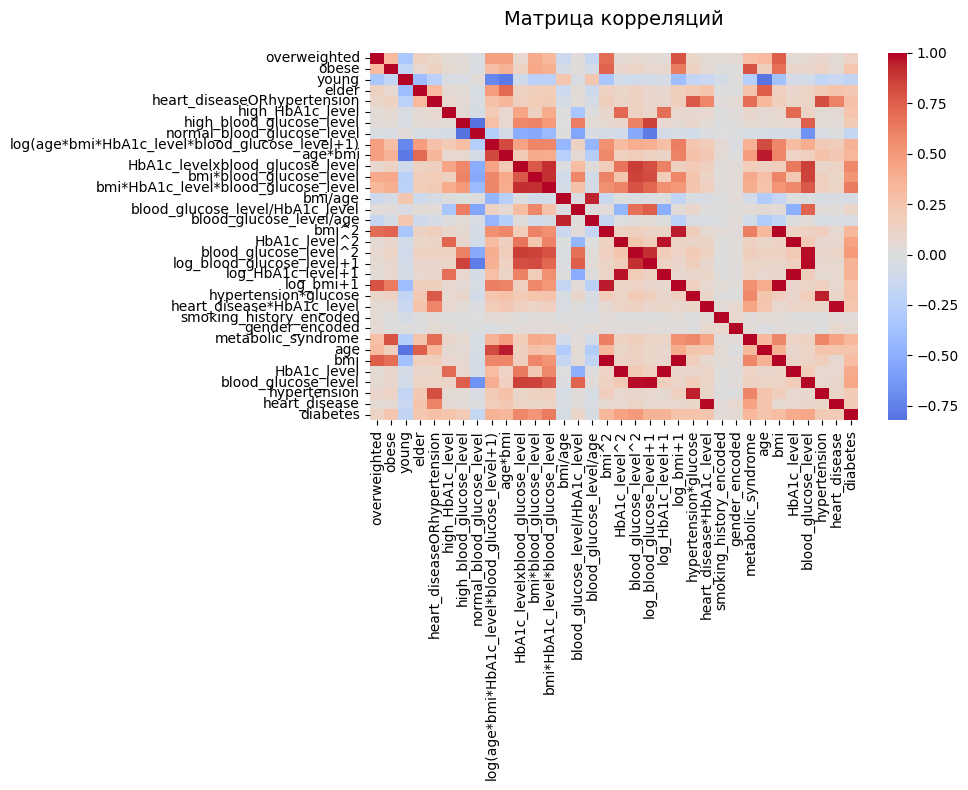

In [70]:
new_features = ['overweighted', 'obese', 'young', 'elder', 'heart_diseaseORhypertension', 'high_HbA1c_level', 'high_blood_glucose_level', 'normal_blood_glucose_level',
                'log(age*bmi*HbA1c_level*blood_glucose_level+1)', 'age*bmi', 'HbA1c_levelxblood_glucose_level', 'bmi*blood_glucose_level', 'bmi*HbA1c_level*blood_glucose_level',
                'bmi/age', 'blood_glucose_level/HbA1c_level', 'blood_glucose_level/age', 'bmi^2', 'HbA1c_level^2', 'blood_glucose_level^2', 'log_blood_glucose_level+1', 'log_HbA1c_level+1', 'log_bmi+1',
                'hypertension*glucose', 'heart_disease*HbA1c_level', 'smoking_history_encoded', 'gender_encoded', 'metabolic_syndrome']

old_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease', 'diabetes']


corr_matrix = diabetes_new_features[new_features + old_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Уменьшим мультиколлинеарность и упростим модель. Для этого удалю числовые признаки, которые имеют высокую корреляцию с другими. Исключу признаки с корреляцией Пирсона выше порогового значения = 0,95.

In [71]:
def drop_highly_correlated_features(df, threshold=0.95):
    df_clean = df.copy()
    corr_matrix = df_clean.corr().abs()
    upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    high_corr_pairs = np.where((corr_matrix > threshold) & upper_triangle)
    to_drop = set()
    for i, j in zip(*high_corr_pairs):
        feature_i = corr_matrix.columns[i]
        feature_j = corr_matrix.columns[j]
        if corr_matrix[feature_i].mean() > corr_matrix[feature_j].mean():
            to_drop.add(feature_j)
        else:
            to_drop.add(feature_i)
    df_clean = df_clean.drop(columns=to_drop)
    return df_clean

diabetes_new_features = drop_highly_correlated_features(diabetes_new_features[new_features + old_features])

Поссмотрим, что сейчас представляет из себя матрица корреляции

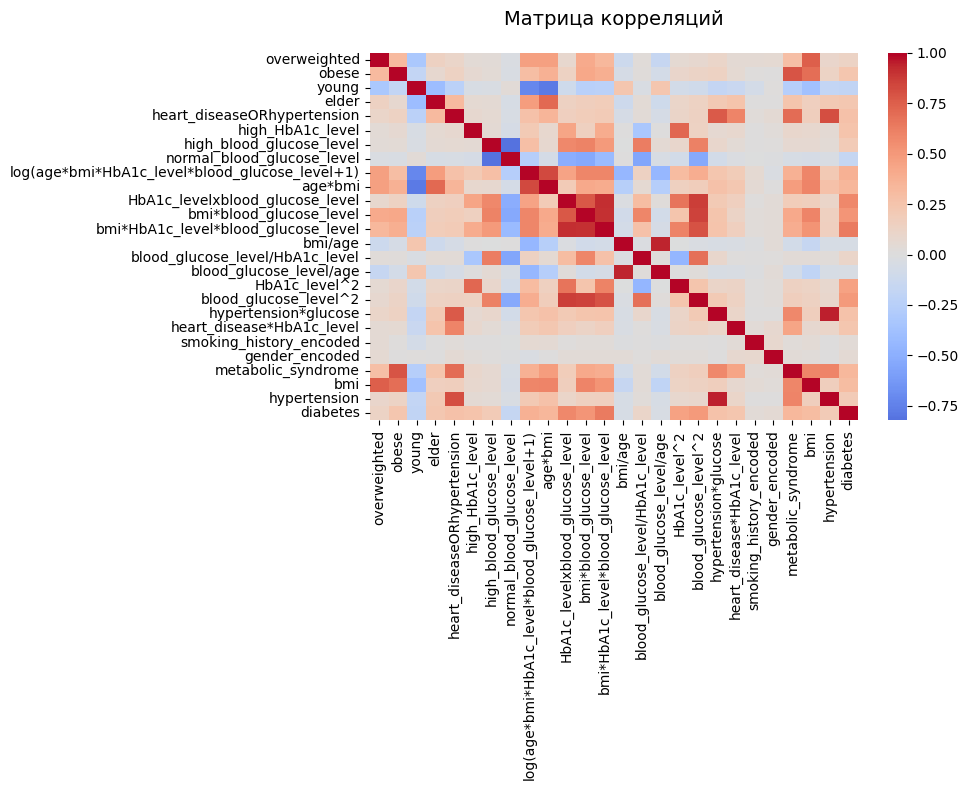

In [72]:
corr_matrix = diabetes_new_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Посмортим на результат после создания новых фич

Для начала снова подготовим данные

In [73]:

# Разделим выборки на train и test,
# Но т.к. нужно удалить выбросы только, для train выборки, то делаем:

from sklearn.preprocessing import RobustScaler

diabetes_X = diabetes_df.drop('diabetes', axis=1)
diabetes_y = diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42,
)

diabetes_train_df = pd.DataFrame(diabetes_X_train, columns=diabetes_X.columns)
diabetes_train_df['diabetes'] = diabetes_y_train

diabetes_test_df = pd.DataFrame(diabetes_X_test, columns=diabetes_X.columns)
diabetes_test_df['diabetes'] = diabetes_y_test

# Удалим выбросы только для train
diabetes_train_df = remove_outliers_iqr_by_group(diabetes_train_df, 'bmi', 'diabetes')

# Создаем фичи
diabetes_train_df = create_features(diabetes_train_df)
diabetes_test_df = create_features(diabetes_test_df)

# Удалим features, которые имеют высокую корреляцию с другими
diabetes_train_df = drop_highly_correlated_features(diabetes_train_df)
diabetes_test_df = diabetes_test_df[diabetes_train_df.columns]

# Снова отделим target от всех остальных данных
diabetes_X_train = diabetes_train_df.drop('diabetes', axis=1)
diabetes_y_train = diabetes_train_df['diabetes']

diabetes_X_test = diabetes_test_df.drop('diabetes', axis=1)
diabetes_y_test = diabetes_test_df['diabetes']

# Применим RobustScaler, т.к. он устойчив к выбросам
scaler = RobustScaler()
diabetes_X_train = pd.DataFrame(scaler.fit_transform(diabetes_X_train), columns=diabetes_X_train.columns)
diabetes_X_test = pd.DataFrame(scaler.transform(diabetes_X_test), columns=diabetes_X_test.columns)

Кросс-валидация и выбор лучшей модели по fbeta-score (beta = 1,2,3)

In [74]:
import warnings
from sklearn.model_selection import cross_val_score
import optuna

warnings.filterwarnings('ignore', category=UserWarning)
def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='accuracy', n_jobs=-1):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'random_state': 42
        }
        
        model = DecisionTreeClassifier(**params)
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params


best_params = {
    'f1': {'max_depth': 26, 'min_samples_split': 38, 'min_samples_leaf': 8, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'},
    'f2': {'max_depth': 38, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'},
    'f3': {'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'entropy'}
}

for beta in [1, 2, 3]:
    scorer = make_scorer(fbeta_score, beta=beta) 
    if not best_params.get(f'f{beta}'):
        best_params[f'f{beta}'] = find_best_hyperparameters_cv(
            diabetes_X_train,
            diabetes_y_train,
            n_trials=50,
            cv=StratifiedKFold(n_splits=5),
            scoring=scorer
        )
    
    print(f"\n=== Best Model f{beta} on validation ===")
    print(f"Best params: {best_params[f'f{beta}']}")



=== Best Model f1 on validation ===
Best params: {'max_depth': 26, 'min_samples_split': 38, 'min_samples_leaf': 8, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'}

=== Best Model f2 on validation ===
Best params: {'max_depth': 38, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'}

=== Best Model f3 on validation ===
Best params: {'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'entropy'}


Подберем оптимальный threshold для каждой из моделей и каждой из fbeta метрик

In [75]:
optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    for model_name in [1, 2, 3]:
        model = DecisionTreeClassifier(**best_params[f'f{model_name}'])
        
        model, threshold, fold_score = find_optimal_threshhold_cv(
            model,
            diabetes_X_train,
            diabetes_y_train,
            cv=5,
            f_beta=beta,
            report=True
        )
        if optimal_models.get(f'f{beta}'):
            if fold_score['f_beta_score'] > optimal_fold_scores[f'f{beta}']['f_beta_score']:
                optimal_models[f'f{beta}'] = model
                optimal_thresholds[f'f{beta}'] = threshold
                optimal_fold_scores[f'f{beta}'] = fold_score
        else:
            optimal_models[f'f{beta}'] = model
            optimal_thresholds[f'f{beta}'] = threshold
            optimal_fold_scores[f'f{beta}'] = fold_score


=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1336
           1       0.92      0.80      0.86       130

    accuracy                           0.98      1466
   macro avg       0.95      0.90      0.92      1466
weighted avg       0.98      0.98      0.98      1466

Best f1-score: 0.8560
Best f2-score: 0.8215
Best f3-score: 0.8106
Best f1-score: 0.8560
Best threshold: 0.6

=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1336
           1       0.88      0.81      0.84       130

    accuracy                           0.97      1466
   macro avg       0.93      0.90      0.91      1466
weighted avg       0.97      0.97      0.97      1466

Best f1-score: 0.8400
Best f2-score: 0.8203
Best f3-score: 0.8140
Best f1-score: 0.8400
Best threshold: 0.5555555555555556

=== Best Model

Посмотрим, что получилось на валидации

In [76]:
for beta in [1, 2, 3]:
    print(optimal_fold_scores[f'f{beta}']['classification_report'])
    print(f"Best f{beta}-score: {optimal_fold_scores[f'f{beta}']['f_beta_score']:.4f}")
    

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1336
           1       0.92      0.80      0.86       130

    accuracy                           0.98      1466
   macro avg       0.95      0.90      0.92      1466
weighted avg       0.98      0.98      0.98      1466

Best f1-score: 0.8560
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1336
           1       0.82      0.83      0.83       130

    accuracy                           0.97      1466
   macro avg       0.90      0.91      0.91      1466
weighted avg       0.97      0.97      0.97      1466

Best f2-score: 0.8295
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1336
           1       0.58      0.88      0.70       130

    accuracy                           0.93      1466
   macro avg       0.78      0.91      0.83      1466
weighted avg       0.95      0

Проведем замеры на тестовой выборке

In [77]:
for beta in [1, 2, 3]:
    model = optimal_models[f'f{beta}']
    threshold = optimal_thresholds[f'f{beta}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{beta} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{beta}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=beta):.4f}")
    print(f"threshold: {threshold}")


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1830
           1       0.85      0.74      0.79       170

    accuracy                           0.97      2000
   macro avg       0.91      0.86      0.89      2000
weighted avg       0.97      0.97      0.97      2000

f1-score: 0.7900
f2-score: 0.7600
f3-score: 0.7504
f1-score: 0.7900
threshold: 0.6

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1830
           1       0.75      0.79      0.77       170

    accuracy                           0.96      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.96      0.96      0.96      2000

f1-score: 0.7714
f2-score: 0.7849
f3-score: 0.7895
f2-score: 0.7849
threshold: 0.375

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1830


Вывод: улучшения повысили детекцию класса 1 (есть диабет), особенно recall. Лучший баланс между precision и recall показывает модель, где оптимизировалась метрика f1. Однако если нам нужно найти всех реально больных, то лучше использовать модель, где оптимизировалась метрика f2

### 4.  Имплементация алгоритма машинного обучения 

4.1. Задача классификации

In [78]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y
from scipy import stats

class LabDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    
    class Node:
        def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
            self.feature_idx = feature_idx
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
    
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1, 
                 max_features=None, splitter='best', criterion='gini', random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.splitter = splitter
        self.criterion = criterion
        self.random_state = random_state
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        y = y.astype(int)
        
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_in_ = X.shape[1]
        
        self.root = self._build_tree(X, y, depth=0)
        return self

    def _get_feature_indices(self, n_features):
        if self.max_features is None:
            return np.arange(n_features)
        elif self.max_features == 'sqrt':
            n = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n = max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            n = min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            n = max(1, int(self.max_features * n_features))
        else:
            n = n_features
        n = max(1, min(n, n_features))
        return np.random.choice(n_features, size=n, replace=False)

    def _build_tree(self, X, y, depth):
        n_samples = X.shape[0]
        
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            np.all(y == y[0])):
            return self.Node(value=self._leaf_value(y))
        
        feature_indices = self._get_feature_indices(X.shape[1])
        
        if self.splitter == 'best':
            best_feature, best_threshold = self._find_best_split(X, y, feature_indices)
        else:
            best_feature, best_threshold = self._find_random_split(X, y, feature_indices)
        
        if best_feature is None:
            return self.Node(value=self._leaf_value(y))
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
            return self.Node(value=self._leaf_value(y))
        
        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return self.Node(feature_idx=best_feature, threshold=best_threshold,
                         left=left_node, right=right_node)

    def _find_best_split(self, X, y, feature_indices):
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        n_total = y.size
        
        parent_impurity = self._calculate_impurity(y)
        
        for fid in feature_indices:
            feature = X[:, fid]
            if np.all(feature == feature[0]):
                continue
            
            sort_idx = np.argsort(feature)
            y_sorted = y[sort_idx]
            x_sorted = feature[sort_idx]
            
            valid_splits = np.where(x_sorted[1:] != x_sorted[:-1])[0] + 1
            if valid_splits.size == 0:
                continue
            
            valid_splits = valid_splits[
                (valid_splits >= self.min_samples_leaf) & 
                (n_total - valid_splits >= self.min_samples_leaf)
            ]
            if valid_splits.size == 0:
                continue
            
            for i in valid_splits:
                left_y = y_sorted[:i]
                right_y = y_sorted[i:]
                
                left_impurity = self._calculate_impurity(left_y)
                right_impurity = self._calculate_impurity(right_y)
                
                weighted_impurity = (len(left_y) * left_impurity + len(right_y) * right_impurity) / n_total
                gain = parent_impurity - weighted_impurity
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = fid
                    best_threshold = (x_sorted[i - 1] + x_sorted[i]) / 2.0
        
        return best_feature, best_threshold

    def _calculate_impurity(self, y):
        n_samples = y.size
        if n_samples == 0:
            return 0
        
        counts = np.bincount(y, minlength=self.n_classes_)
        probabilities = counts / n_samples
        
        if self.criterion == 'gini':
            return 1.0 - np.sum(probabilities ** 2)
        elif self.criterion == 'entropy':
            return stats.entropy(probabilities[probabilities > 0])
        elif self.criterion == 'log_loss':
            return stats.entropy(probabilities[probabilities > 0])
        else:
            return 1.0 - np.max(probabilities)

    def _find_random_split(self, X, y, feature_indices):
        fid = np.random.choice(feature_indices)
        col = X[:, fid]
        if np.all(col == col[0]):
            return None, None
        threshold = np.random.uniform(col.min(), col.max())
        return fid, threshold

    def _leaf_value(self, y):
        counts = np.bincount(y, minlength=self.n_classes_)
        probs = counts / y.size
        return probs

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        probs = np.empty((X.shape[0], self.n_classes_), dtype=np.float64)
        for i in range(X.shape[0]):
            node = self.root
            while node.value is None:
                if X[i, node.feature_idx] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            probs[i] = node.value
        return probs

Проверим работоспособность этого класса

Повторим все действия снова

Сначала с простым бейзлайном

In [79]:
gender_dummies = pd.get_dummies(diabetes_df['gender'], drop_first=True)
smoking_history_dummies = pd.get_dummies(diabetes_df['smoking_history'], drop_first=True)
onehot_diabetes_df = pd.concat([diabetes_df, gender_dummies, smoking_history_dummies], axis=1)

onehot_diabetes_df.drop(['gender', 'smoking_history'], axis=1, inplace=True)
diabetes_X = onehot_diabetes_df.drop('diabetes', axis=1)
diabetes_y = onehot_diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

In [80]:
model = LabDecisionTreeClassifier(max_depth=20)

optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    optimal_models[f'f{beta}'], optimal_thresholds[f'f{beta}'], optimal_fold_scores[f'f{beta}'] = find_optimal_threshhold_cv(
        model,
        diabetes_X_train,
        diabetes_y_train,
        cv=5,
        f_beta=beta,
        report=True
    )


=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1464
           1       0.74      0.74      0.74       136

    accuracy                           0.96      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.96      0.96      0.96      1600

Best f1-score: 0.7380
Best f2-score: 0.7364
Best f3-score: 0.7358
Best f1-score: 0.7380
Best threshold: 1.0

=== Best Model f2 on validation ===
Best fold: 2
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1464
           1       0.71      0.75      0.73       136

    accuracy                           0.95      1600
   macro avg       0.84      0.86      0.85      1600
weighted avg       0.95      0.95      0.95      1600

Best f1-score: 0.7312
Best f2-score: 0.7424
Best f3-score: 0.7462
Best f2-score: 0.7424
Best threshold: 1.0

=== Best Model f3 on validati

Проведем замеры на тестовой выборке

In [81]:
for f_score in [1, 2, 3]:
    model = optimal_models[f'f{f_score}']
    threshold = optimal_thresholds[f'f{f_score}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{f_score} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{f_score}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=f_score):.4f}") 


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1830
           1       0.79      0.74      0.76       170

    accuracy                           0.96      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.96      0.96      0.96      2000

f1-score: 0.7636
f2-score: 0.7500
f3-score: 0.7456
f1-score: 0.7636

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1830
           1       0.78      0.75      0.76       170

    accuracy                           0.96      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.96      0.96      0.96      2000

f1-score: 0.7628
f2-score: 0.7533
f3-score: 0.7501
f2-score: 0.7533

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1830
           1       0.78      0.7

Вывод: результат оказался таким же как и в KNeighborsClassifier из sklearn

Теперь улучшим бейзлайн

In [82]:
diabetes_X = diabetes_df.drop('diabetes', axis=1)
diabetes_y = diabetes_df['diabetes']
diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = train_test_split(
    diabetes_X,
    diabetes_y,
    test_size=0.2,
    stratify=diabetes_y,
    random_state=42
)

diabetes_train_df = pd.DataFrame(diabetes_X_train, columns=diabetes_X.columns)
diabetes_train_df['diabetes'] = diabetes_y_train

diabetes_test_df = pd.DataFrame(diabetes_X_test, columns=diabetes_X.columns)
diabetes_test_df['diabetes'] = diabetes_y_test

# Удалим выбросы только для train
diabetes_train_df = remove_outliers_iqr_by_group(diabetes_train_df, 'bmi', 'diabetes')

# Создаем фичи
diabetes_train_df = create_features(diabetes_train_df)
diabetes_test_df = create_features(diabetes_test_df)

# Удалим features, которые имеют высокую корреляцию с другими
diabetes_train_df = drop_highly_correlated_features(diabetes_train_df)
diabetes_test_df = diabetes_test_df[diabetes_train_df.columns]

# Снова отделим target от всех остальных данных
diabetes_X_train = diabetes_train_df.drop('diabetes', axis=1)
diabetes_y_train = diabetes_train_df['diabetes']

diabetes_X_test = diabetes_test_df.drop('diabetes', axis=1)
diabetes_y_test = diabetes_test_df['diabetes']

# Применим RobustScaler, т.к. он устойчив к выбросам
scaler = RobustScaler()
diabetes_X_train = pd.DataFrame(scaler.fit_transform(diabetes_X_train), columns=diabetes_X_train.columns)
diabetes_X_test = pd.DataFrame(scaler.transform(diabetes_X_test), columns=diabetes_X_test.columns)

Подберем гиперпараметры

In [83]:
import warnings
from sklearn.model_selection import cross_val_score
import optuna

warnings.filterwarnings('ignore', category=UserWarning)
def find_best_hyperparameters_cv(X, y, n_trials=10, cv=5, scoring='accuracy', n_jobs=-1):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'random_state': 42
        }
        
        model = LabDecisionTreeClassifier(**params)
        
        return cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params


best_params = {
    'f1': {'max_depth': 26, 'min_samples_split': 38, 'min_samples_leaf': 8, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'},
    'f2': {'max_depth': 38, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'},
    'f3': {'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'entropy'}
}

for beta in [1, 2, 3]:
    scorer = make_scorer(fbeta_score, beta=beta) 
    if not best_params.get(f'f{beta}'):
        best_params[f'f{beta}'] = find_best_hyperparameters_cv(
            diabetes_X_train,
            diabetes_y_train,
            n_trials=50,
            cv=StratifiedKFold(n_splits=5),
            scoring=scorer
        )
    
    print(f"\n=== Best Model f{beta} on validation ===")
    print(f"Best params: {best_params[f'f{beta}']}")



=== Best Model f1 on validation ===
Best params: {'max_depth': 26, 'min_samples_split': 38, 'min_samples_leaf': 8, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'}

=== Best Model f2 on validation ===
Best params: {'max_depth': 38, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'gini'}

=== Best Model f3 on validation ===
Best params: {'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best', 'criterion': 'entropy'}


In [84]:
optimal_models = {}      
optimal_thresholds = {}
optimal_fold_scores = {}

for beta in [1, 2, 3]:
    for model_name in [1, 2, 3]:
        model = LabDecisionTreeClassifier(**best_params[f'f{model_name}'])
        
        model, threshold, fold_score = find_optimal_threshhold_cv(
            model,
            diabetes_X_train,
            diabetes_y_train,
            cv=5,
            f_beta=beta,
            report=True
        )
        if optimal_models.get(f'f{beta}'):
            if fold_score['f_beta_score'] > optimal_fold_scores[f'f{beta}']['f_beta_score']:
                optimal_models[f'f{beta}'] = model
                optimal_thresholds[f'f{beta}'] = threshold
                optimal_fold_scores[f'f{beta}'] = fold_score
        else:
            optimal_models[f'f{beta}'] = model
            optimal_thresholds[f'f{beta}'] = threshold
            optimal_fold_scores[f'f{beta}'] = fold_score


=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1336
           1       0.92      0.80      0.86       130

    accuracy                           0.98      1466
   macro avg       0.95      0.90      0.92      1466
weighted avg       0.98      0.98      0.98      1466

Best f1-score: 0.8560
Best f2-score: 0.8215
Best f3-score: 0.8106
Best f1-score: 0.8560
Best threshold: 0.6

=== Best Model f1 on validation ===
Best fold: 3
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1336
           1       0.88      0.81      0.84       130

    accuracy                           0.97      1466
   macro avg       0.93      0.90      0.91      1466
weighted avg       0.97      0.97      0.97      1466

Best f1-score: 0.8400
Best f2-score: 0.8203
Best f3-score: 0.8140
Best f1-score: 0.8400
Best threshold: 0.5555555555555556

=== Best Model

Посмотрим, что получилось на валидации

In [85]:
for beta in [1, 2, 3]:
    print(optimal_fold_scores[f'f{beta}']['classification_report'])
    print(f"Best f{beta}-score: {optimal_fold_scores[f'f{beta}']['f_beta_score']:.4f}")

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1336
           1       0.92      0.80      0.86       130

    accuracy                           0.98      1466
   macro avg       0.95      0.90      0.92      1466
weighted avg       0.98      0.98      0.98      1466

Best f1-score: 0.8560
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1336
           1       0.82      0.83      0.83       130

    accuracy                           0.97      1466
   macro avg       0.90      0.91      0.91      1466
weighted avg       0.97      0.97      0.97      1466

Best f2-score: 0.8295
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1336
           1       0.57      0.88      0.69       130

    accuracy                           0.93      1466
   macro avg       0.78      0.91      0.83      1466
weighted avg       0.95      0

Проведем замеры на тестовой выборке

In [86]:
for beta in [1, 2, 3]:
    model = optimal_models[f'f{beta}']
    threshold = optimal_thresholds[f'f{beta}']
    
    y_prob_test = model.predict_proba(diabetes_X_test)[:, 1]
    y_pred_test = (y_prob_test >= threshold).astype(int)
    
    print(f"\n=== Test Model f{beta} ===")
    print(classification_report(diabetes_y_test, y_pred_test))
    print(f"f1-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=1):.4f}")
    print(f"f2-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=2):.4f}")
    print(f"f3-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=3):.4f}")
    print(f"f{beta}-score: {fbeta_score(diabetes_y_test, y_pred_test, beta=beta):.4f}")
    print(f"threshold: {threshold}")


=== Test Model f1 ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1830
           1       0.85      0.74      0.79       170

    accuracy                           0.97      2000
   macro avg       0.91      0.86      0.89      2000
weighted avg       0.97      0.97      0.97      2000

f1-score: 0.7900
f2-score: 0.7600
f3-score: 0.7504
f1-score: 0.7900
threshold: 0.6

=== Test Model f2 ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1830
           1       0.75      0.79      0.77       170

    accuracy                           0.96      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.96      0.96      0.96      2000

f1-score: 0.7714
f2-score: 0.7849
f3-score: 0.7895
f2-score: 0.7849
threshold: 0.375

=== Test Model f3 ===
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1830


Вывод: результат оказался таким же как и в KNeighborsClassifier из sklearn